In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install cufflinks

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import requests
import re
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont


df = pd.read_csv('titanic-passengers.csv',encoding="ISO-8859-1",sep=";")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,343,No,2,"Collander, Mr. Erik Gustaf",male,28.0,0,0,248740,13.0000,NaN,S
1,76,No,3,"Moen, Mr. Sigurd Hansen",male,25.0,0,0,348123,7.6500,F G73,S
2,641,No,3,"Jensen, Mr. Hans Peder",male,20.0,0,0,350050,7.8542,NaN,S
3,568,No,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",female,29.0,0,4,349909,21.0750,NaN,S
4,672,No,1,"Davidson, Mr. Thornton",male,31.0,1,0,F.C. 12750,52.0000,B71,S


Data description: 
_
Survival - Survival (0 = No; 1 = Yes). Not included in test.csv file.
Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
Name - Name
Sex - Sex
Age - Age
Sibsp - Number of Siblings/Spouses Aboard
Parch - Number of Parents/Children Aboard
Ticket - Ticket Number
Fare - Passenger Fare
Cabin - Cabin
Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [5]:
train = pd.read_csv('titanic-passengers.csv',encoding="ISO-8859-1",sep=";")
test = pd.read_csv('titanic-passengers.csv',encoding="ISO-8859-1",sep=";")

In [6]:
PassengerId = test['PassengerId']

In [7]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,343,No,2,"Collander, Mr. Erik Gustaf",male,28.0,0,0,248740,13.0000,NaN,S
1,76,No,3,"Moen, Mr. Sigurd Hansen",male,25.0,0,0,348123,7.6500,F G73,S
2,641,No,3,"Jensen, Mr. Hans Peder",male,20.0,0,0,350050,7.8542,NaN,S


In [8]:
original_train = train.copy()

In [9]:
full_data = [train, test]

In [10]:
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

In [11]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

In [12]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

In [13]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [14]:
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

In [15]:
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

In [16]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

In [17]:
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

In [18]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [19]:
for dataset in full_data:
    dataset['Survived'] = dataset['Survived'].map( {'No': 0, 'Yes': 1} ).astype(int)
    
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare']                               = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare']                                  = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    dataset.loc[ dataset['Age'] <= 16, 'Age']                          = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

In [20]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [21]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,2,1,1,0,1,0,0,1,1,1
1,0,3,1,1,0,0,0,1,1,1,1
2,0,3,1,1,0,0,0,0,1,1,1


<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

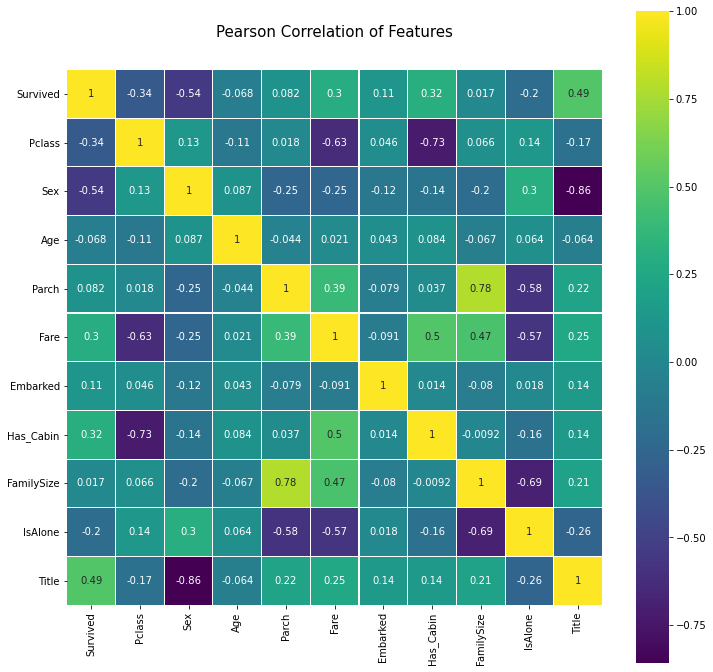

In [22]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [23]:
train[['Title', 'Survived']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

Survived           
           mean count  sum
Title                     
1      0.156673   517   81
2      0.575000    40   23
3      0.793651   126  100
4      0.702703   185  130
5      0.347826    23    8

In [24]:
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).agg(['mean', 'count', 'sum'])

Survived           
         mean count  sum
Sex                     
0    0.742038   314  233
1    0.188908   577  109

In [25]:
title_and_sex = original_train.copy()[['Name', 'Sex']]
title_and_sex['Title'] = title_and_sex['Name'].apply(get_title)
title_and_sex['Sex'] = title_and_sex['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
title_and_sex[['Title', 'Sex']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

Sex           
              mean count  sum
Title                        
Capt      1.000000     1    1
Col       1.000000     2    2
Countess  0.000000     1    0
Don       1.000000     1    1
Dr        0.857143     7    6
Jonkheer  1.000000     1    1
Lady      0.000000     1    0
Major     1.000000     2    2
Master    1.000000    40   40
Miss      0.000000   182    0
Mlle      0.000000     2    0
Mme       0.000000     1    0
Mr        1.000000   517  517
Mrs       0.000000   125    0
Ms        0.000000     1    0
Rev       1.000000     6    6
Sir       1.000000     1    1

In [26]:
def get_gini_impurity(survived_count, total_count):
    survival_prob = survived_count/total_count
    not_survival_prob = (1 - survival_prob)
    random_observation_survived_prob = survival_prob
    random_observation_not_survived_prob = (1 - random_observation_survived_prob)
    mislabelling_survided_prob = not_survival_prob * random_observation_survived_prob
    mislabelling_not_survided_prob = survival_prob * random_observation_not_survived_prob
    gini_impurity = mislabelling_survided_prob + mislabelling_not_survided_prob
    return gini_impurity

In [27]:
gini_impurity_starting_node = get_gini_impurity(342, 891)
gini_impurity_starting_node

0.47301295786144265

In [28]:
gini_impurity_men = get_gini_impurity(109, 577)
gini_impurity_men

0.3064437162277843

In [29]:
gini_impurity_women = get_gini_impurity(233, 314)
gini_impurity_women

0.3828350034484158

In [30]:
men_weight = 577/891
women_weight = 314/891
weighted_gini_impurity_sex_split = (gini_impurity_men * men_weight) + (gini_impurity_women * women_weight)

sex_gini_decrease = weighted_gini_impurity_sex_split - gini_impurity_starting_node
sex_gini_decrease

-0.13964795747285214

In [31]:
gini_impurity_title_1 = get_gini_impurity(81, 517)
gini_impurity_title_1

0.26425329886377663

In [32]:
gini_impurity_title_others = get_gini_impurity(261, 374)
gini_impurity_title_others

0.42170207898424317

In [33]:
title_1_weight = 517/891
title_others_weight = 374/891
weighted_gini_impurity_title_split = (gini_impurity_title_1 * title_1_weight) + (gini_impurity_title_others * title_others_weight)

title_gini_decrease = weighted_gini_impurity_title_split - gini_impurity_starting_node
title_gini_decrease

-0.14267004758907514

In [34]:
cv = KFold(n_splits=10)
accuracies = list()
max_attributes = len(list(test))
depth_range = range(1, max_attributes + 1)

for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    for train_fold, valid_fold in cv.split(train):
        f_train = train.loc[train_fold]
        f_valid = train.loc[valid_fold]

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                               y = f_train["Survived"])
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                                y = f_valid["Survived"])
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)

df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.778939
         2          0.792360
         3          0.824944
         4          0.829401
         5          0.805843
         6          0.799101
         7          0.802409
         8          0.802434
         9          0.799076
        10          0.803558
        11          0.792335


In [39]:
conda remove graphviz 

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\21265\anaconda3

  removed specs:
    - graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    backports.functools_lru_cache-1.6.4|     pyhd3eb1b0_0           9 KB
    backports.tempfile-1.0     |     pyhd3eb1b0_1          11 KB
    ca-certificates-2020.10.14 |                0         122 KB
    conda-package-handling-1.7.3|   py38h8cc25b3_1         721 KB
    openssl-1.1.1h             |       he774522_0         4.8 MB
    ------------------------------------------------------------
                                           Total:         5.7 MB

The following packages will be REMOVED:

  graphviz-2.38-hfd603c8_2
  pydot-1.4.1-py38_0

The following packages will be UPDATED:

  backports.functoo~                             1.6.1-py_0 --> 1.6.4-pyhd3eb1b0_0
  conda-package-han~            


InvalidArchiveError('Error with archive C:\\Users\\21265\\anaconda3\\pkgs\\openssl-1.1.1h-he774522_0xze_j8d_\\pkg-openssl-1.1.1h-he774522_0.tar.zst.  You probably need to delete and re-download or re-create this file.  Message from libarchive was:\n\nCould not unlink')



In [40]:
conda install python-graphviz

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\21265\anaconda3

  added / updated specs:
    - python-graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python-graphviz-0.16       |     pyhd3eb1b0_1          20 KB
    ------------------------------------------------------------
                                           Total:          20 KB

The following NEW packages will be INSTALLED:

  python-graphviz    pkgs/main/noarch::python-graphviz-0.16-pyhd3eb1b0_1




python-graphviz-0.16 | 20 KB     |            |   0% 
python-graphviz-0.16 | 20 KB     | #######8   |  78% 
python-graphviz-0.16 | 20 KB     | ########## | 100% 
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [42]:
import graphviz 

In [62]:
from sklearn.tree import DecisionTreeClassifier

In [66]:
dtree = tree.DecisionTreeClassifier()

In [70]:
with open("tree_1.dot") as f:
    dot_graph = f.read()

FileNotFoundError: [Errno 2] No such file or directory: 'tree_1.dot'

In [67]:
graphviz.Source(dot_graph).view()

NameError: name 'dot_graph' is not defined

In [68]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=data_train.columns.values,  
                         class_names=['Survived','Not Survived'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [74]:
dot_data = tree.export_graphviz(tree_optimized, 
                                out_file=None,
                                filled=True, 
                                rounded=True,  
                                special_characters=True,
                               feature_names = train_columns) 
graph = graphviz.Source(dot_data)
graph

NameError: name 'tree_optimized' is not defined